In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.legend_handler import HandlerBase

from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

import os
import re

import h5py
from tqdm import tqdm

from utils import load_and_format_data_as_df, get_birds_in_time_range, get_velocity_order_parameter, get_variance_ratios, get_number_densities, downsample_A2B

ImportError: cannot import name 'get_variance_ratios' from 'utils' (/Users/mmccraw/dev/yale/courses/integrated-workshop/project/code/data/utils.py)

In [2]:
# # this will load the data from the hdf5 file and format it as a pandas dataframe
# # the hdf5 files need to be in the current directory (same as the notebook)
# # ONLY RUN THIS CELL ONCE TO GET THE CSV FILES

# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         path = os.path.join(dirname, filename)
#         if '.hdf5' in filename:
#             print(f'loading {path}')
#             df = load_and_format_data_as_df(path)
#             df.to_csv(f"./{filename.replace('.hdf5', '.csv')}", index=False)
#             print(f'saved under {filename.replace(".hdf5", ".csv")}')

In [3]:
df_A = pd.read_csv('A_nodes.csv', index_col=0)
df_B = pd.read_csv('B_nodes.csv', index_col=0)
df_C = pd.read_csv('C_nodes.csv', index_col=0)

In [4]:
# data encompasses "flock formation, circling, and landing" over a 30 minute period
# ~1800 chimney swift birds
# there are regions reported where the birds are highly correlated - when flying - and less correlated - when landing - as the intention of the study

In [5]:
# range of time in minutes
(df_A.time.max() - df_A.time.min()) / 60, (df_B.time.max() - df_B.time.min()) / 60, (df_C.time.max() - df_C.time.min()) / 60

(8.505727950172396, 9.431653876098322, 8.19263708152597)

In [6]:
# individual time ranges for tracks
# A
df_A.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    24966.000000
mean         7.405351
std          6.848828
min          0.934268
25%          2.535869
50%          5.071738
75%         10.010010
max        100.066733
dtype: float64

In [7]:
# individual time ranges for tracks
# B
df_B.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    78498.000000
mean         6.520097
std          5.619826
min          0.934268
25%          2.435769
50%          4.671338
75%          8.842176
max         59.092426
dtype: float64

In [8]:
# individual time ranges for tracks
# C
df_C.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    39403.000000
mean         4.478242
std          3.859843
min          0.934268
25%          1.968635
50%          3.169837
75%          5.472139
max         42.442442
dtype: float64

In [30]:
# velocity order parameter
vel_order_A = get_velocity_order_parameter(df_A)
vel_order_B = get_velocity_order_parameter(df_B)
vel_order_C = get_velocity_order_parameter(df_C)

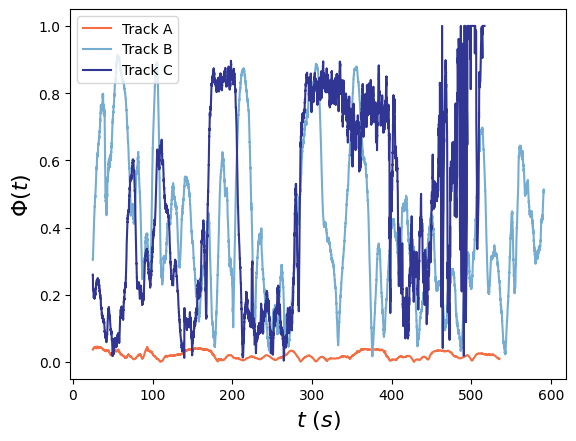

In [223]:
import mdaux
colors = mdaux.getValToColorMap([-1, 0, 1, 2, 3, 4])
plt.plot(np.sort(df_A.time.unique()), vel_order_A, label='Track A', color=colors[0])
plt.plot(np.sort(df_B.time.unique()), vel_order_B, label='Track B', color=colors[3])
plt.plot(np.sort(df_C.time.unique()), vel_order_C, label='Track C', color=colors[4])
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel('$\Phi(t)$', fontsize=16)
plt.savefig('velocity_order_parameter.png', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
vars_A = get_variance_ratios(df_A)
vars_B = get_variance_ratios(df_B)
vars_C = get_variance_ratios(df_C)

100%|██████████| 4881/4881 [00:08<00:00, 546.13it/s]


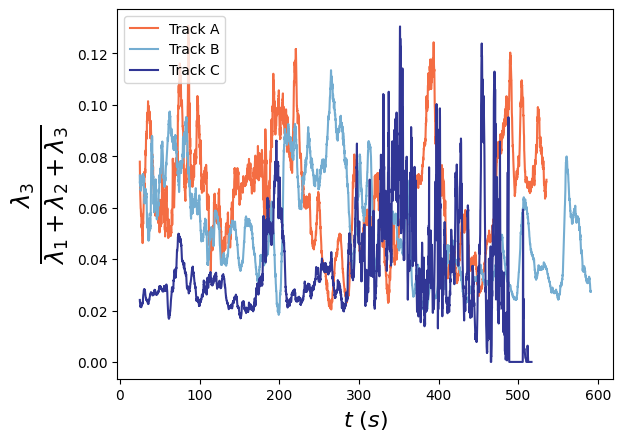

In [109]:
plt.plot(np.linspace(df_A.time.min(), df_A.time.max(), len(vars_A)), vars_A[:, 2], label='Track A', color=colors[0])
plt.plot(np.linspace(df_B.time.min(), df_B.time.max(), len(vars_B)), vars_B[:, 2], label='Track B', color=colors[3])
plt.plot(np.linspace(df_C.time.min(), df_C.time.max(), len(vars_C)), vars_C[:, 2], label='Track C', color=colors[4])
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.savefig('variance_ratios.png', dpi=300, bbox_inches='tight')
plt.show()

In [122]:
# get density
densities_A = get_number_densities(df_A)
densities_B = get_number_densities(df_B)
densities_C = get_number_densities(df_C)

 95%|█████████▍| 4623/4881 [00:09<00:00, 533.96it/s]/var/folders/0b/4bnfdhq15v3cy5c13mgg2z_00000gn/T/ipykernel_64359/472382927.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  densities.append(sub_df.tid.nunique() / volume)
100%|██████████| 4881/4881 [00:09<00:00, 497.97it/s]


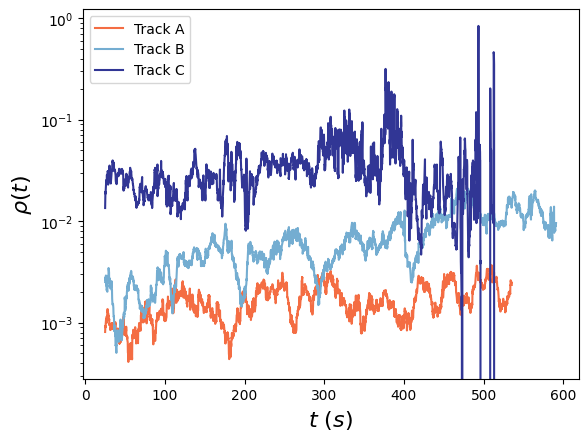

In [131]:
plt.plot(np.linspace(df_A.time.min(), df_A.time.max(), len(densities_A)), densities_A, label='Track A', color=colors[0])
plt.plot(np.linspace(df_B.time.min(), df_B.time.max(), len(densities_B)), densities_B, label='Track B', color=colors[3])
plt.plot(np.linspace(df_C.time.min(), df_C.time.max(), len(densities_C[densities_C < 1e6])), densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.yscale('log')
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('number_density.png', dpi=300, bbox_inches='tight')

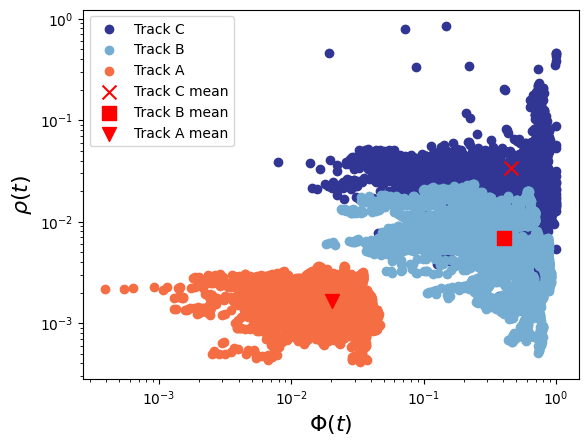

In [177]:
# correlation between velocity order parameter and density
plt.scatter(downsample_A2B(vel_order_C, densities_C[densities_C < 1e6]), densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.scatter(downsample_A2B(vel_order_B, densities_B), densities_B, label='Track B', color=colors[3])
plt.scatter(downsample_A2B(vel_order_A, densities_A), densities_A, label='Track A', color=colors[0])
plt.scatter(np.mean(downsample_A2B(vel_order_C, densities_C[densities_C < 1e6])), np.mean(densities_C[densities_C < 1e6]), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_B, densities_B)), np.mean(densities_B), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_A, densities_A)), np.mean(densities_A), label='Track A mean', color='r', marker='v', s=100)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('velocity_order_parameter_vs_density.png', dpi=300, bbox_inches='tight')

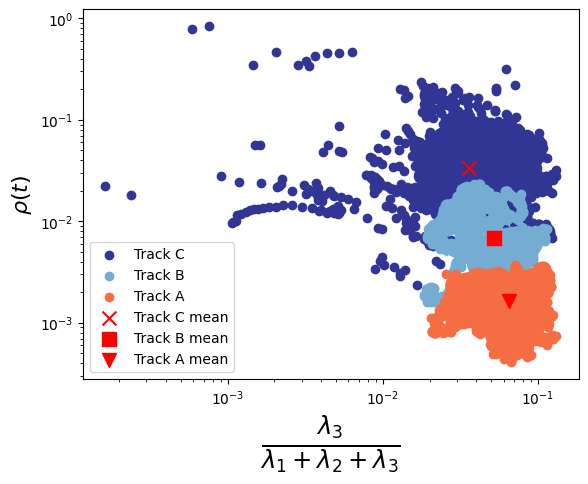

In [178]:
# correlation between velocity order parameter and density
plt.scatter(vars_C[:, 2][densities_C < 1e6], densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.scatter(vars_B[:, 2], densities_B, label='Track B', color=colors[3])
plt.scatter(vars_A[:, 2], densities_A, label='Track A', color=colors[0])
plt.scatter(np.mean(vars_C[:, 2][densities_C < 1e6]), np.mean(densities_C[densities_C < 1e6]), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(vars_B[:, 2]), np.mean(densities_B), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(vars_A[:, 2]), np.mean(densities_A), label='Track A mean', color='r', marker='v', s=100)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('variance_ratios_vs_density.png', dpi=300, bbox_inches='tight')

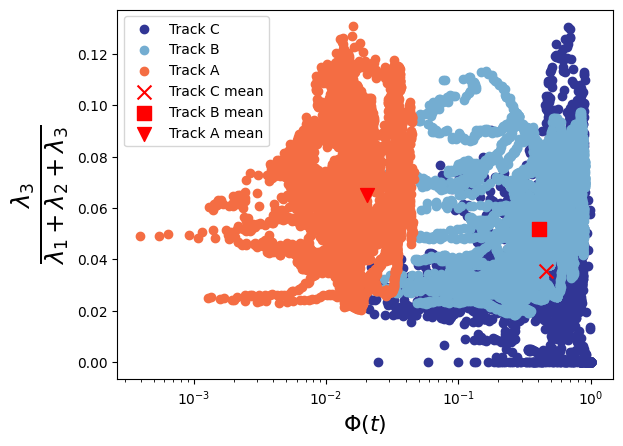

In [284]:
plt.scatter(downsample_A2B(vel_order_C, vars_C[:, 2]), vars_C[:, 2], label='Track C', color=colors[4])
plt.scatter(downsample_A2B(vel_order_B, vars_B[:, 2]), vars_B[:, 2], label='Track B', color=colors[3])
plt.scatter(downsample_A2B(vel_order_A, vars_A[:, 2]), vars_A[:, 2], label='Track A', color=colors[0])
plt.scatter(np.mean(downsample_A2B(vel_order_C, vars_C[:, 2])), np.mean(vars_C[:, 2]), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_B, vars_B[:, 2])), np.mean(vars_B[:, 2]), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_A, vars_A[:, 2])), np.mean(vars_A[:, 2]), label='Track A mean', color='r', marker='v', s=100)
plt.xscale('log')
plt.legend()
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.savefig('velocity_order_parameter_vs_variance_ratios.png', dpi=300, bbox_inches='tight')

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1373/1373 [00:01<00:00, 738.02it/s]


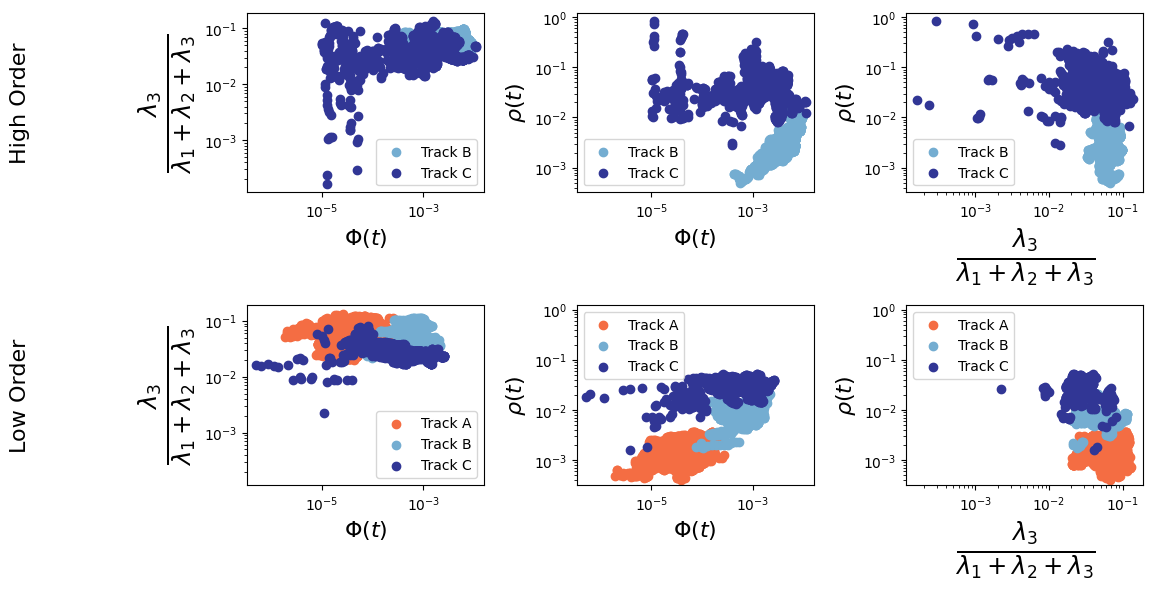

In [287]:
# is there common behavior in the high ordered regime and low ordered regime?
phi_high = 0.6
phi_low = 0.2

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# vel_order_A[vel_order_A > phi_high].time

labels = ['Track A', 'Track B', 'Track C']
dfs = [df_A, df_B, df_C]
vel_orders = [vel_order_A, vel_order_B, vel_order_C]
cs = [colors[0], colors[3], colors[4]]

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    df_sub = df[df.time.isin(vel_order[vel_order > phi_high].index.values)].copy()
    vel = get_velocity_order_parameter(df_sub)
    var = get_variance_ratios(df_sub)
    dens = get_number_densities(df_sub)
    if df_sub.shape[0] > 0:
        axs[0, 0].scatter(downsample_A2B(vel, var[:, 2][var[:, 2] > 1e-9]), var[:, 2][var[:, 2] > 1e-9], label=label, color=color)
        axs[0, 1].scatter(downsample_A2B(vel, dens[dens < 1e6]), dens[dens < 1e6], label=label, color=color)
        axs[0, 2].scatter(var[:, 2][dens < 1e6], dens[dens < 1e6], label=label, color=color)

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    df_sub = df[df.time.isin(vel_order[vel_order < phi_low].index.values)].copy()
    vel = get_velocity_order_parameter(df_sub)
    var = get_variance_ratios(df_sub)
    dens = get_number_densities(df_sub)
    if df_sub.shape[0] > 0:
        axs[1, 0].scatter(downsample_A2B(vel, var[:, 2][var[:, 2] > 1e-9]), var[:, 2][var[:, 2] > 1e-9], label=label, color=color)
        axs[1, 1].scatter(downsample_A2B(vel, dens[dens < 1e6]), dens[dens < 1e6], label=label, color=color)
        axs[1, 2].scatter(var[:, 2][dens < 1e6], dens[dens < 1e6], label=label, color=color)

for i, _ in enumerate(axs):
    axs[i, 0].set_xlabel('$\Phi(t)$', fontsize=16)
    axs[i, 0].set_ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
    axs[i, 1].set_xlabel('$\Phi(t)$', fontsize=16)
    axs[i, 1].set_ylabel(r'$\rho(t)$', fontsize=16)
    axs[i, 2].set_xlabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
    axs[i, 2].set_ylabel(r'$\rho(t)$', fontsize=16)
    for j, ax in enumerate(_):
        ax.legend()
        # if j != 0:
        ax.set_yscale('log')
        ax.set_xscale('log')

for i, ax in enumerate(axs[0]):
    x_low = np.inf
    x_high = -np.inf
    y_low = np.inf
    y_high = -np.inf
    for j, _ in enumerate(axs):
        x_low = min(x_low, axs[j, i].get_xlim()[0])
        x_high = max(x_high, axs[j, i].get_xlim()[1])
        y_low = min(y_low, axs[j, i].get_ylim()[0])
        y_high = max(y_high, axs[j, i].get_ylim()[1])
    for j, _ in enumerate(axs):
        axs[j, i].set_xlim(x_low, x_high)
        axs[j, i].set_ylim(y_low, y_high)

label_offset = 0.75
axs[0, 0].text(-label_offset, 0.5, 'High Order', va='center', ha='left', rotation='vertical', transform=axs[0, 0].transAxes, fontsize=16)
axs[1, 0].text(-label_offset, 0.5, 'Low Order', va='center', ha='left', rotation='vertical', transform=axs[1, 0].transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('high_vs_low_order_correlations.png', dpi=300, bbox_inches='tight')

In [206]:


df = get_birds_in_time_range(df_A, time_start=40, time_end=42.5)
